# Lezen van de files

Importeren libraries

In [1]:
import h5py
import os
import numpy as np
import random


Hier 1 class van maken, doet:
* lezen van de data
* Specificeren van de folder waarvan je de data wil inlezen in folder

## Class voor all preprocess stappen

### DATA PREPROCC (niet nodig als je de arrays gebruikt)

### Inlezen INTRA - Drive


In [2]:
# Inladen voor INTRA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X_test = np.load('/content/drive/MyDrive/arrays_intra/X_test.npy')
X_train = np.load('/content/drive/MyDrive/arrays_intra/X_train.npy')

y_test = np.load('/content/drive/MyDrive/arrays_intra/y_test.npy')
y_train  = np.load('/content/drive/MyDrive/arrays_intra/y_train.npy')

In [4]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
X_test.shape

(8, 17812, 248)

### Trainen + Maken van het model (intra)

### LSTM met hyperparametertuning

In [7]:
!pip3 install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [8]:
y_train_encoded.shape

(32, 4)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

def build_model_storedParams(loaded_hyperparameters): # dit is de versie die met json params verder gaat
    model = Sequential()

    # Adding LSTM layers as per loaded hyperparameters
    for i in range(loaded_hyperparameters['num_lstm_layers']):
        model.add(LSTM(
            units=loaded_hyperparameters[f'units_{i}'],
            return_sequences=i < loaded_hyperparameters['num_lstm_layers'] - 1,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            dropout=loaded_hyperparameters.get('lstm_dropout_', 0)))

    # Adding Dense layers as per loaded hyperparameters
    for i in range(loaded_hyperparameters['num_dense_layers']):
        model.add(Dense(
            units=loaded_hyperparameters[f'dense_units_{i}'],
            activation='relu'))

    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=tf.keras.optimizers.Adam(loaded_hyperparameters['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_model(hp):
    model = Sequential()

    # Tuning the number of LSTM layers and their units
    for i in range(hp.Int('num_lstm_layers', 1, 4)):
        model.add(LSTM(
            units=hp.Choice('units_' + str(i), values=[16, 32, 64, 128]), #values=[16, 32, 64, 128]
            return_sequences=i < hp.get('num_lstm_layers') - 1,  # Only the last layer should not return sequences
            input_shape=(X_train.shape[1], X_train.shape[2]),
            dropout=hp.Choice('lstm_dropout_', values=[0.1, 0.2, 0.3, 0.4, 0.5])))

    # Tuning the number of Dense layers and their units
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(Dense(
            units=hp.Choice('dense_units_' + str(i), values=[16, 32, 64, 128]), #values=[16, 32, 64, 128]
            activation='relu'))

    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), #values=[1e-2, 1e-3, 1e-4]
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='./',
    project_name='hparam_tuning'
)

tuner.search_space_summary()

# Start the hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=10, batch_size=8, validation_data=(X_test, y_test_encoded))
# epochs + batch size voor nu constant (behalve epochs bij fitten van model)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 04m 15s]
val_accuracy: 0.6666666666666666

Best val_accuracy So Far: 0.6666666666666666
Total elapsed time: 00h 41m 32s


In [10]:
# voor normale getuned params
print(f"""
The hyperparameter search is complete.
The optimal number of LSTM and Dense layers and their units can be reviewed in the best hyperparameters.
""")

## Early stopping om te kijken of het effect heeft om het aantal epochs te verhogen
# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Increase the number of epochs as needed
epochs = 50
# Build the model with the optimal hyperparameters and train it

model = tuner.hypermodel.build(best_hps) ### HIER SWITCHEN NAAR BESTE HYPER PARAMETERS OF INLADEN VIA JSON loaded_hyperparameters

#model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test)) # epochs aanpassen voor snelheid
# deze was redelijk:
#model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded)) # kleinere batch size kan miss helpen? sotnd eerst op 64

model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=8, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping_callback])

# beste model als callback opslaan met .h5 of best params opslaan als file


The hyperparameter search is complete.
The optimal number of LSTM and Dense layers and their units can be reviewed in the best hyperparameters.

Epoch 1/50
4/4 [==============================] - 15s 2s/step - loss: 1.4329 - accuracy: 0.1875 - val_loss: 1.3904 - val_accuracy: 0.3750
Epoch 2/50
4/4 [==============================] - 6s 2s/step - loss: 1.3976 - accuracy: 0.2500 - val_loss: 1.3926 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 7s 2s/step - loss: 1.3918 - accuracy: 0.1875 - val_loss: 1.3853 - val_accuracy: 0.5000
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 1.3932 - accuracy: 0.1562 - val_loss: 1.3761 - val_accuracy: 0.2500
Epoch 5/50
4/4 [==============================] - 7s 2s/step - loss: 1.3909 - accuracy: 0.1875 - val_loss: 1.3803 - val_accuracy: 0.5000
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 1.3923 - accuracy: 0.2188 - val_loss: 1.3795 - val_accuracy: 0.2500
Epoch 7/50
4/4 [===========

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 17812, 128)        193024    
                                                                 
 lstm_4 (LSTM)               (None, 17812, 16)         9280      
                                                                 
 lstm_5 (LSTM)               (None, 64)                20736     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 128)               2176      
                                                                 
 dense_7 (Dense)             (None, 4)                

In [12]:
## To see the best hyper params + valuesL:
print("Best Hyperparameters:")
for hyperparam in best_hps.values:
    print(f"{hyperparam}: {best_hps.get(hyperparam)}")

Best Hyperparameters:
num_lstm_layers: 3
units_0: 128
lstm_dropout_: 0.3
num_dense_layers: 3
dense_units_0: 32
learning_rate: 0.01
dense_units_1: 16
dense_units_2: 128
dense_units_3: 32
units_1: 16
units_2: 64
units_3: 128


1/1 [==============================] - 2s 2s/step


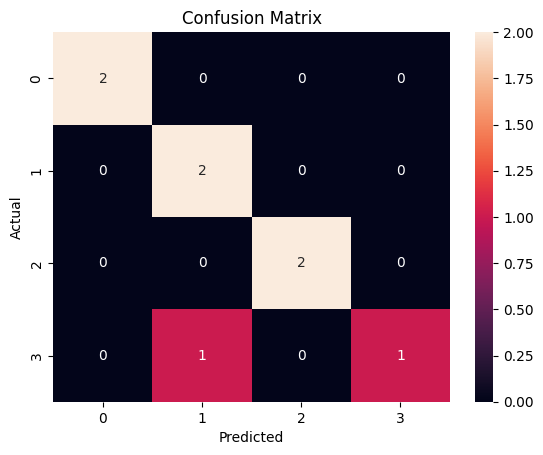

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2

    accuracy                           0.88         8
   macro avg       0.92      0.88      0.87         8
weighted avg       0.92      0.88      0.87         8



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report for additional metrics
print(classification_report(np.argmax(y_test_encoded, axis=1), y_pred_classes))

In [14]:
# Evaluating the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

1/1 [==============================] - 4s 4s/step - loss: 1.3664 - accuracy: 0.3125
Training Accuracy: 31.25%
1/1 [==============================] - 1s 1s/step - loss: 1.3154 - accuracy: 0.8750
Test Accuracy: 87.50%


## Proberen het vaker te runnen

Training Run 1/10
Training Run 2/10
Training Run 3/10
Training Run 4/10
Training Run 5/10
Training Run 6/10
Training Run 7/10
Training Run 8/10
Training Run 9/10
Training Run 10/10
Average Training Accuracy: 0.32%
Average Test Accuracy: 0.44%
Best Model Test Accuracy: 0.62%
1/1 [==============================] - 2s 2s/step


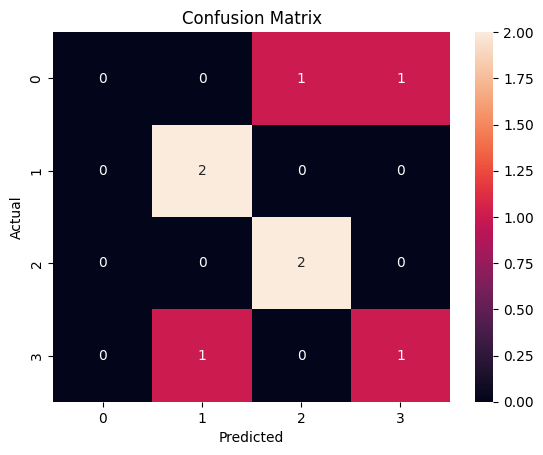

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         2
           2       0.67      1.00      0.80         2
           3       0.50      0.50      0.50         2

    accuracy                           0.62         8
   macro avg       0.46      0.62      0.53         8
weighted avg       0.46      0.62      0.53         8



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already loaded
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

def build_model_from_best_hps(best_hps):
    model = Sequential()
    model.add(LSTM(units=best_hps['units_0'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=best_hps['lstm_dropout_']))
    model.add(LSTM(units=best_hps['units_1'], return_sequences=best_hps['num_lstm_layers'] > 2))
    if best_hps['num_lstm_layers'] > 2:
        model.add(LSTM(units=best_hps['units_2']))
    model.add(Dense(units=best_hps['dense_units_0'], activation='relu'))
    model.add(Dense(units=best_hps['dense_units_1'], activation='relu'))
    if best_hps['num_dense_layers'] > 2:
        model.add(Dense(units=best_hps['dense_units_2'], activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
best_hps = {'num_lstm_layers': 3, 'units_0': 128, 'lstm_dropout_': 0.3, 'num_dense_layers': 3, 'dense_units_0': 32, 'learning_rate': 0.01, 'dense_units_1': 16, 'dense_units_2': 128, 'dense_units_3': 32, 'units_1': 16, 'units_2': 64, 'units_3': 128}

num_runs = 10
all_train_accuracies = []
all_test_accuracies = []
best_accuracy = 0
best_model = None

for run in range(num_runs):
    print(f"Training Run {run+1}/{num_runs}")

    model = build_model_from_best_hps(best_hps)
    model.fit(X_train, y_train_encoded, epochs=50, batch_size=8, validation_data=(X_test, y_test_encoded), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], verbose=0)

    train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

    all_train_accuracies.append(train_accuracy)
    all_test_accuracies.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = tf.keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())

print(f"Average Training Accuracy: {np.mean(all_train_accuracies):.2f}%")
print(f"Average Test Accuracy: {np.mean(all_test_accuracies):.2f}%")
print(f"Best Model Test Accuracy: {best_accuracy:.2f}%")

# Confusion Matrix and Classification Report for the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(np.argmax(y_test_encoded, axis=1), y_pred_classes))


In [8]:
best_accuracy

0.625

In [9]:
all_train_accuracies

[0.25, 0.34375, 0.34375, 0.4375, 0.25, 0.25, 0.34375, 0.3125, 0.3125, 0.3125]

In [10]:
all_test_accuracies

[0.5, 0.5, 0.375, 0.625, 0.375, 0.25, 0.625, 0.5, 0.5, 0.125]

### Handmatige